## Basic Spatial Analysis in R

A few examples of basic operation in R.  Use the data sets created previously in "Simple Spatial Features in R".

In [1]:
library(raster)
library(rgeos)

load("sample_forest.RData")
load("sample_tracts.RData")
load("sample_temps.RData")

Loading required package: sp

rgeos version: 0.5-2, (SVN revision 621)
 GEOS runtime version: 3.6.2-CAPI-1.10.2 
 Linking to sp version: 1.3-2 
 Polygon checking: TRUE 




#### Plot Everything

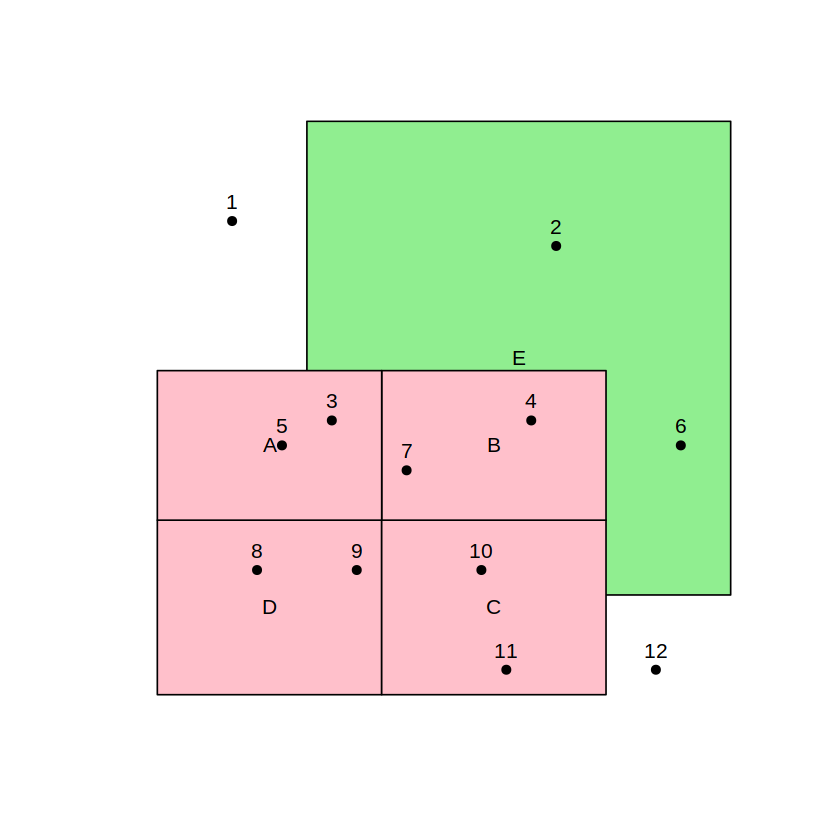

In [2]:
plot(as(raster::extent(2.0, 25.0, 2.0, 25.0), "SpatialPolygons"), col = "transparent", border = "transparent")

# SPDF features
plot(sample_forest, col = "lightgreen", add = TRUE)
plot(sample_tracts, col = "pink", add = TRUE)

# Label the polygons with their names
a = suppressWarnings(rgeos::polygonsLabel(sample_tracts, sample_tracts$name, method = "centroid", doPlot = TRUE))
b = suppressWarnings(rgeos::polygonsLabel(sample_forest, sample_forest$name, method = "buffer", doPlot = TRUE))

# Plot the points and label them
# See http://www.sthda.com/english/wiki/r-plot-pch-symbols-the-different-point-shapes-available-in-r
plot(sample_temps, add = TRUE, col = "black", pch = 16)
# Label the points
text(sample_temps, labels = sample_temps$id, pos = 3)

### Basic dissolve (st_union group by)

Dissolve out the tracts into 2 new features based on the "zone" field.

In [3]:
sample_tracts@data

,name,id,county,type,zone
,<fct>,<dbl>,<dbl>,<fct>,<dbl>
1.1,A,1,1,tract,1
1.2,B,2,1,tract,1
1.3,C,3,1,tract,2
1.4,D,4,1,tract,2


### Solution:

zone
<chr>
1
2


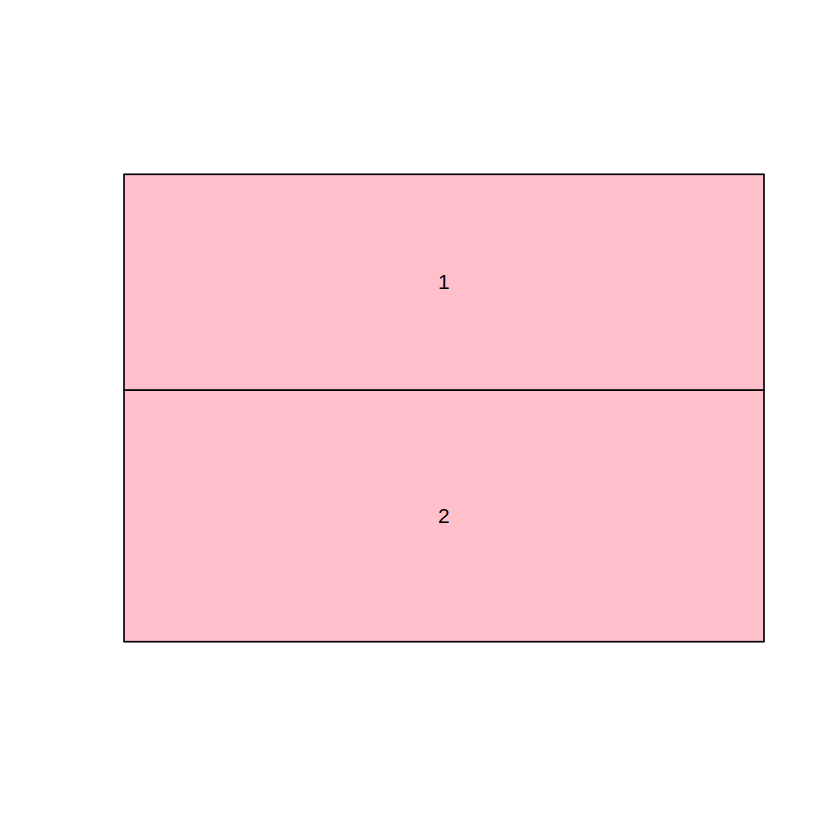

In [4]:
## Use rgeos::gUnaryUnion
# Problem with this method is that we lose the SpatialPolygonsDataFrame and instead get back a 
# SpatialPolygons object with row.names that match the dissolve code.  Honestly, this is stupid.
# Solution is to make a "dissolvePolygons" function that will take the rownames and add them back into the
# dissolved polygons as a dataframe which has a column name that matches the dissolve field.

dissolvePolygons <- function (
    input_SPDF, # SPDF object to dissolve
    diss_field # name of column to dissolve by, as string
    ) {
    diss_command <- sprintf("rgeos::gUnaryUnion(input_SPDF, input_SPDF$%s)", diss_field)
    data_command <- sprintf("data.frame(%s = row.names(out_polys), stringsAsFactors = FALSE)", diss_field)
    out_polys <- eval(parse(text = diss_command))
    data <- eval(parse(text = data_command))
    output_SPDF <- SpatialPolygonsDataFrame(out_polys,data)
    
    return(output_SPDF)
    }

# Usage
zones <- dissolvePolygons(sample_tracts, "zone")
zones@data

plot(zones, col = "pink")
z <- suppressWarnings(rgeos::polygonsLabel(zones, zones$zone, method = "buffer", doPlot = TRUE))

### Alternate solution: raster::aggregate

Better in almost every way.  Except syntax.

,name,id,county,type,zone
,<fct>,<dbl>,<dbl>,<fct>,<dbl>
1.1,A,1,1,tract,1
1.2,B,2,1,tract,1
1.3,C,3,1,tract,2
1.4,D,4,1,tract,2


zone,type,county
<dbl>,<fct>,<dbl>
1,tract,1
2,tract,1


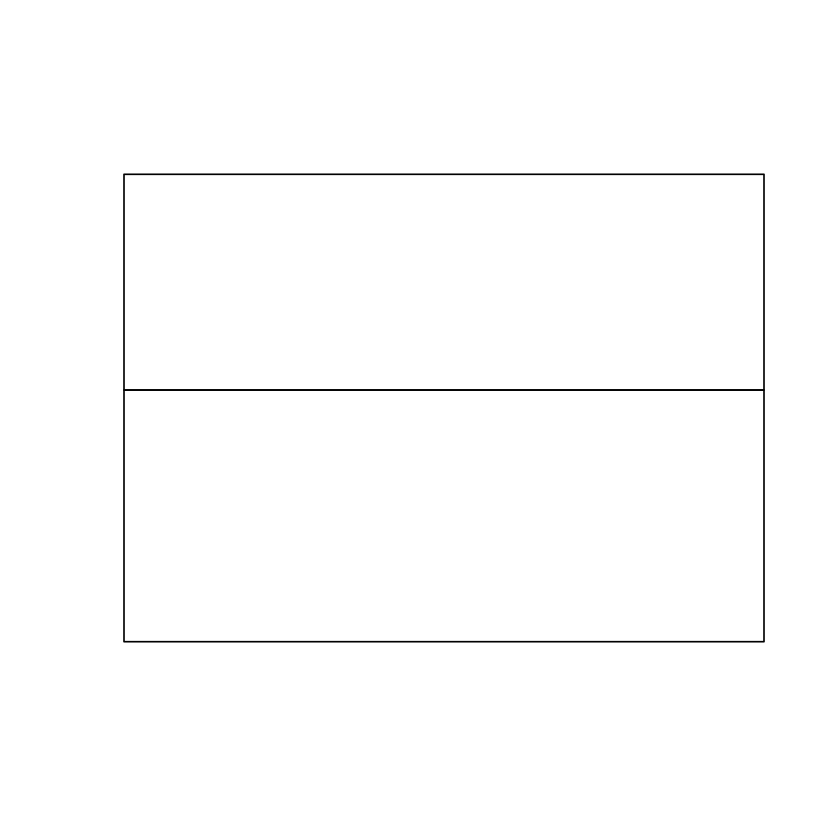

In [5]:
sample_tracts@data

zoned_tracts <- raster::aggregate(sample_tracts, 
                                  by='zone', sums=list(list(function(x)x[1], c('type','county')  )))
plot(zoned_tracts)
zoned_tracts@data

## Polygon Clipping, Intersections, etc.

All pretty much nuances of the same thing.  What regions intersect other regions and either return the bits that intersect, or the ones that don't.

### Return the regions that intersect.

,name,id,county,type,zone
,<fct>,<dbl>,<dbl>,<fct>,<dbl>
1,A,1,1,tract,1
2,B,2,1,tract,1
3,C,3,1,tract,2
4,D,4,1,tract,2


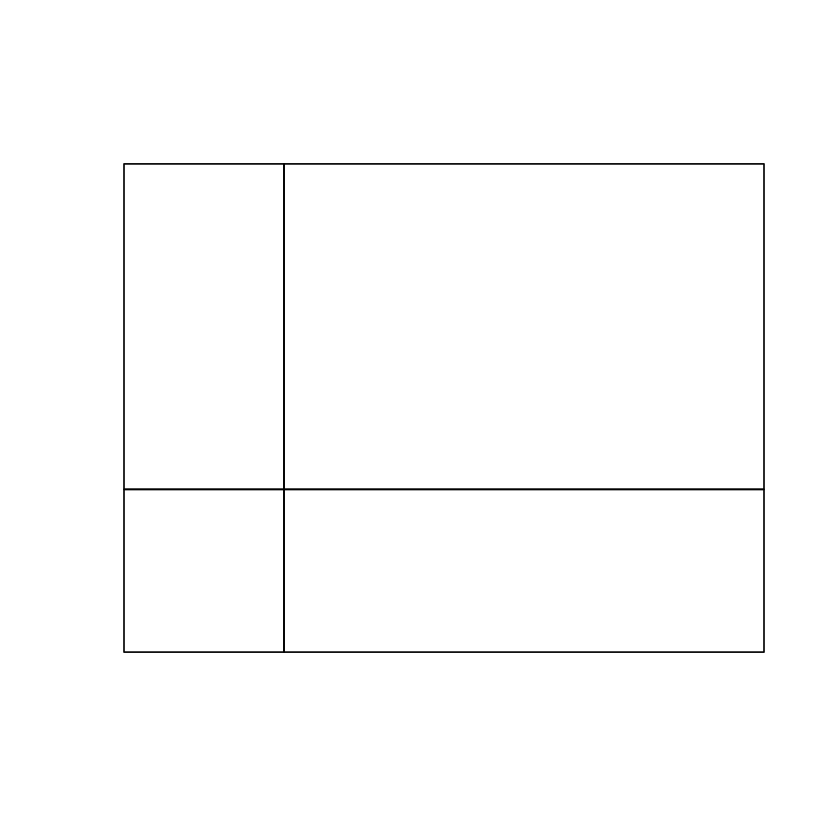

In [6]:
# Calculate the rgeos::gintersection between 'sample_tracts' and 'sample_forest'.  What do we get back?  Well,
# as I'm beginning to expect, we get back geometry that is usable, but our data is junked.

# What about using the raster::intersect instead?
# It's better, but still not great.  It merges the contents of both dataframes together and if there are 
# matching column names, it renames them <name>.1 or <name>.2 depending on the order that was passed into the 
# function. Not really ideal imho.  Would be nice to have greater flexibility in how attributes are kept.

simpleClip <- function(
    # Returns the intersection of spdf_1 and spdf 2
    # but only returns attributes for spdf_1
    spdf_1,
    spdf_2
) {
    clipped <- raster::intersect(spdf_1, spdf_2)
    keepN <- ncol(spdf_1@data) # Only keep the 1st N cols that belong to spdf_1
    data <- clipped@data[1:keepN]
    names(data) <- sub("\\.1", "", colnames(data))
    clipped@data <- data
    return(clipped)
}

# Also, what if I want to only keep the geometry of one set and not the other?

tracts_in_forest <- simpleClip(sample_tracts, sample_forest)

plot(tracts_in_forest)
tracts_in_forest@data